In [ ]:
import os
import json
from collections import Counter
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from PIL import Image

import matplotlib.pyplot as plt

from create_dataset import ClimbingHoldDataset  # your dataset class


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")  # for Apple Silicon
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: mps


In [ ]:

IMG_SIZE = 224

augment_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

annotations_dir = "data/annotations"
images_dir = "data/images"

dataset = ClimbingHoldDataset(
    annotations_dir=annotations_dir,
    images_dir=images_dir,
    output_size=(IMG_SIZE, IMG_SIZE)  
)

print("Total samples in dataset:", len(dataset))


dataset.transform = augment_transform

# Inspect label distribution
type_labels_np = np.array([dataset[i]["type"] for i in range(len(dataset))])
orient_labels_np = np.array([dataset[i]["orientation"] for i in range(len(dataset))])

print("type_labels_np shape:", type_labels_np.shape)
print("orient_labels_np shape:", orient_labels_np.shape)

print("Type distribution (by index):", Counter(type_labels_np))
print("Orientation distribution (by index):", Counter(orient_labels_np))


num_types = 7
num_orients = 5

print("num_types:", num_types)
print("num_orients:", num_orients)


train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


batch_size = 16  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Total samples in dataset: 1605
type_labels_np shape: (1605,)
orient_labels_np shape: (1605,)
Type distribution (by index): Counter({np.int64(0): 593, np.int64(3): 307, np.int64(1): 232, np.int64(2): 202, np.int64(4): 132, np.int64(6): 127, np.int64(5): 12})
Orientation distribution (by index): Counter({np.int64(0): 766, np.int64(3): 533, np.int64(2): 211, np.int64(4): 54, np.int64(1): 41})
num_types: 7
num_orients: 5
Train size: 1284, Val size: 321


In [ ]:
from torchvision.models import ResNet50_Weights

class TwoHeadResNet50(nn.Module):
    def __init__(self, num_types=7, num_orientations=5, pretrained=True, dropout=0.3):
        super().__init__()
        weights = ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = models.resnet50(weights=weights)

      
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()

        self.backbone = backbone

        self.type_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_types),
        )

        self.orientation_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_orientations),
        )

    def forward(self, x):
        feats = self.backbone(x)
        type_logits = self.type_head(feats)
        orientation_logits = self.orientation_head(feats)
        return type_logits, orientation_logits


model = TwoHeadResNet50(
    num_types=num_types,
    num_orientations=num_orients,
    pretrained=True,     
    dropout=0.3
).to(device)


for param in model.backbone.parameters():
    param.requires_grad = False

for param in model.type_head.parameters():
    param.requires_grad = True
for param in model.orientation_head.parameters():
    param.requires_grad = True

criterion_type = nn.CrossEntropyLoss()
criterion_orientation = nn.CrossEntropyLoss()


optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,          
    weight_decay=1e-4
)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

print(model)


TwoHeadResNet50(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
num_epochs = 20 

train_losses = []
val_losses = []

train_acc_type = []
train_acc_orientation = []

val_acc_type = []
val_acc_orientation = []

best_val_loss = float("inf")
best_state_dict = None

for epoch in range(num_epochs):
  
    model.train()
    running_loss = 0.0
    correct_type = 0
    correct_orient = 0
    total = 0

    for batch in train_loader:
        imgs = batch["image"].to(device)
        labels_type = batch["type"].to(device)
        labels_orient = batch["orientation"].to(device)

        optimizer.zero_grad()

        out_type, out_orient = model(imgs)

        loss_type = criterion_type(out_type, labels_type)
        loss_orient = criterion_orientation(out_orient, labels_orient)
        loss = loss_type + loss_orient

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        _, preds_type = torch.max(out_type, 1)
        _, preds_orient = torch.max(out_orient, 1)

        correct_type += (preds_type == labels_type).sum().item()
        correct_orient += (preds_orient == labels_orient).sum().item()
        total += imgs.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc_type = correct_type / total
    epoch_train_acc_orientation = correct_orient / total

    train_losses.append(epoch_train_loss)
    train_acc_type.append(epoch_train_acc_type)
    train_acc_orientation.append(epoch_train_acc_orientation)


    model.eval()
    val_running_loss = 0.0
    correct_type_val = 0
    correct_orient_val = 0
    total_val = 0

    all_val_type_true = []
    all_val_type_pred = []
    all_val_orient_true = []
    all_val_orient_pred = []

    with torch.no_grad():
        for batch in val_loader:
            imgs = batch["image"].to(device)
            labels_type = batch["type"].to(device)
            labels_orient = batch["orientation"].to(device)

            out_type, out_orient = model(imgs)

            loss_type = criterion_type(out_type, labels_type)
            loss_orient = criterion_orientation(out_orient, labels_orient)
            loss = loss_type + loss_orient

            val_running_loss += loss.item() * imgs.size(0)

            _, preds_type = torch.max(out_type, 1)
            _, preds_orient = torch.max(out_orient, 1)

            correct_type_val += (preds_type == labels_type).sum().item()
            correct_orient_val += (preds_orient == labels_orient).sum().item()
            total_val += imgs.size(0)

            all_val_type_true.append(labels_type.cpu().numpy())
            all_val_type_pred.append(preds_type.cpu().numpy())
            all_val_orient_true.append(labels_orient.cpu().numpy())
            all_val_orient_pred.append(preds_orient.cpu().numpy())

    epoch_val_loss = val_running_loss / total_val
    epoch_val_acc_type = correct_type_val / total_val
    epoch_val_acc_orientation = correct_orient_val / total_val

    val_losses.append(epoch_val_loss)
    val_acc_type.append(epoch_val_acc_type)
    val_acc_orientation.append(epoch_val_acc_orientation)


    y_true_type_val = np.concatenate(all_val_type_true)
    y_pred_type_val = np.concatenate(all_val_type_pred)
    y_true_orient_val = np.concatenate(all_val_orient_true)
    y_pred_orient_val = np.concatenate(all_val_orient_pred)


    if scheduler is not None:
        scheduler.step(epoch_val_loss)


    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_state_dict = model.state_dict()

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train loss: {epoch_train_loss:.4f} | Val loss: {epoch_val_loss:.4f} | "
        f"Train acc [Type:{epoch_train_acc_type:.3f}, Orient:{epoch_train_acc_orientation:.3f}] | "
        f"Val acc [Type:{epoch_val_acc_type:.3f}, Orient:{epoch_val_acc_orientation:.3f}]"
    )


if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print("Loaded best model (by validation loss).")


Epoch 1/20 | Train loss: 2.9747 | Val loss: 2.5687 | Train acc [Type:0.371, Orient:0.483] | Val acc [Type:0.489, Orient:0.470]
Epoch 2/20 | Train loss: 2.6639 | Val loss: 2.4394 | Train acc [Type:0.436, Orient:0.530] | Val acc [Type:0.539, Orient:0.567]
Epoch 3/20 | Train loss: 2.5109 | Val loss: 2.4587 | Train acc [Type:0.482, Orient:0.558] | Val acc [Type:0.489, Orient:0.586]
Epoch 4/20 | Train loss: 2.5190 | Val loss: 2.4043 | Train acc [Type:0.474, Orient:0.552] | Val acc [Type:0.502, Orient:0.586]
Epoch 5/20 | Train loss: 2.4665 | Val loss: 2.3526 | Train acc [Type:0.494, Orient:0.567] | Val acc [Type:0.489, Orient:0.595]
Epoch 6/20 | Train loss: 2.4346 | Val loss: 2.2723 | Train acc [Type:0.477, Orient:0.571] | Val acc [Type:0.526, Orient:0.611]
Epoch 7/20 | Train loss: 2.3909 | Val loss: 2.3705 | Train acc [Type:0.498, Orient:0.579] | Val acc [Type:0.523, Orient:0.592]
Epoch 8/20 | Train loss: 2.3497 | Val loss: 2.4081 | Train acc [Type:0.498, Orient:0.584] | Val acc [Type:0.520

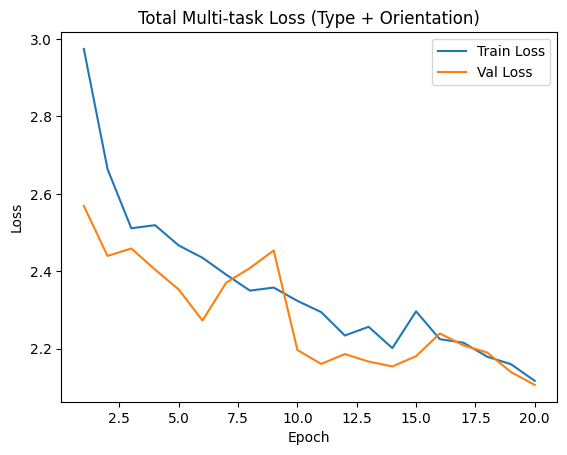

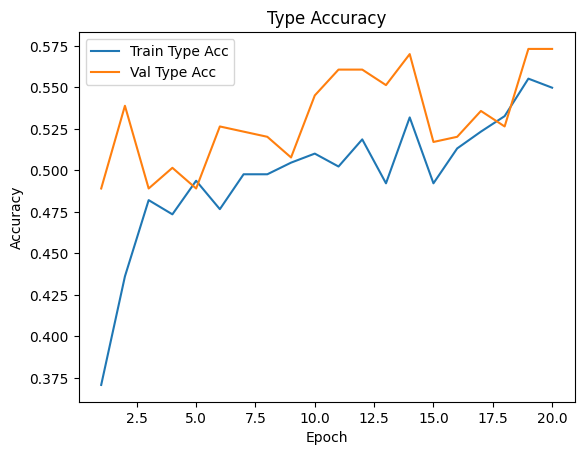

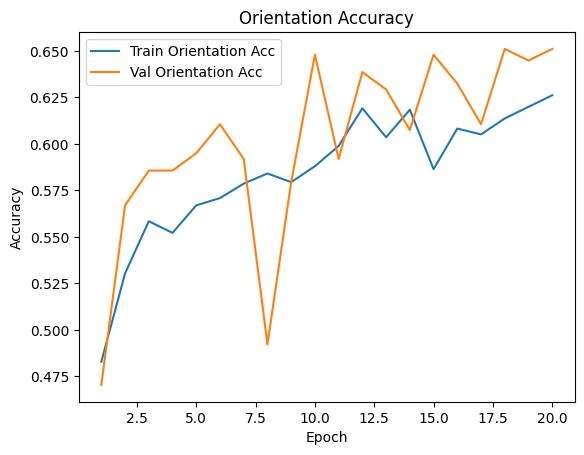

In [49]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Multi-task Loss (Type + Orientation)")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_acc_type, label="Train Type Acc")
plt.plot(epochs, val_acc_type, label="Val Type Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Type Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_acc_orientation, label="Train Orientation Acc")
plt.plot(epochs, val_acc_orientation, label="Val Orientation Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Orientation Accuracy")
plt.legend()
plt.show()


In [50]:
print("Final validation accuracy (from last epoch):")
print("Type       :", val_acc_type[-1])
print("Orientation:", val_acc_orientation[-1])

print("\nDataset label arrays:")
print("type_labels_np shape   :", type_labels_np.shape)
print("orient_labels_np shape :", orient_labels_np.shape)

print("\nValidation NumPy label/pred arrays (last epoch):")
print("y_true_type_val shape   :", y_true_type_val.shape)
print("y_pred_type_val shape   :", y_pred_type_val.shape)
print("y_true_orient_val shape :", y_true_orient_val.shape)
print("y_pred_orient_val shape :", y_pred_orient_val.shape)


Final validation accuracy (from last epoch):
Type       : 0.573208722741433
Orientation: 0.6510903426791277

Dataset label arrays:
type_labels_np shape   : (1605,)
orient_labels_np shape : (1605,)

Validation NumPy label/pred arrays (last epoch):
y_true_type_val shape   : (321,)
y_pred_type_val shape   : (321,)
y_true_orient_val shape : (321,)
y_pred_orient_val shape : (321,)


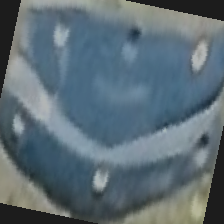

True Type:        Crimp | Predicted: Crimp
True Orientation: Up | Predicted: Up
------------------------------------------------------------


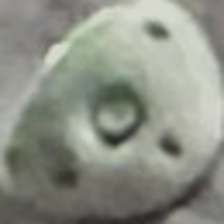

True Type:        Crimp | Predicted: Crimp
True Orientation: UpAng | Predicted: Up
------------------------------------------------------------


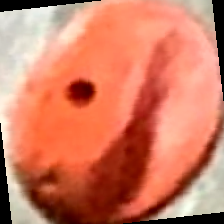

True Type:        Pinch | Predicted: Jug
True Orientation: UpAng | Predicted: Up
------------------------------------------------------------


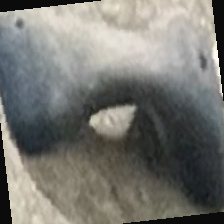

True Type:        Jug | Predicted: Jug
True Orientation: Up | Predicted: Up
------------------------------------------------------------


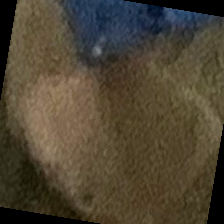

True Type:        Sloper | Predicted: Jug
True Orientation: Up | Predicted: Up
------------------------------------------------------------


In [51]:
import random

TYPE_NAMES = ['Jug', 'Sloper', 'Crimp', 'Jib', 'Pinch', 'Pocket', 'Edge']
ORIENT_NAMES = ['Up', 'Down', 'Side', 'UpAng', 'DownAng']

def show_predictions(n=5):
    model.eval()
    for _ in range(n):
        idx = random.randint(0, len(val_dataset) - 1)
        sample = val_dataset[idx]

        img = sample["image"].unsqueeze(0).to(device)

        with torch.no_grad():
            out_type, out_orient = model(img)

        pred_type = out_type.argmax(1).item()
        pred_orient = out_orient.argmax(1).item()

        true_type = sample["type"]
        true_orient = sample["orientation"]

        type_name_true = TYPE_NAMES[true_type]
        type_name_pred = TYPE_NAMES[pred_type]

        orient_name_true = ORIENT_NAMES[true_orient]
        orient_name_pred = ORIENT_NAMES[pred_orient]

        # De-normalize for display
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        denorm_img = sample["image"] * std + mean
        denorm_img = denorm_img.clamp(0, 1)

        img_pil = transforms.ToPILImage()(denorm_img)

        display(img_pil)
        print(f"True Type:        {type_name_true} | Predicted: {type_name_pred}")
        print(f"True Orientation: {orient_name_true} | Predicted: {orient_name_pred}")
        print("-" * 60)

show_predictions(5)
